# Reproduction of QRAFT

This notebook reconstructs the QRAFT workflow for generating noisy quantum circuit data and training a machine learning model for error mitigation.


## Imports and setup

Load core Qiskit, scikit-learn, and helper libraries used throughout the notebook.


In [1]:
from qiskit.result import Counts
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit.circuit.library import RXGate, RYGate, RZGate, CXGate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, make_scorer

from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Integer, Real, Categorical

import math, random
from __future__ import annotations
from typing import Optional, List, Dict

In [2]:
svc = QiskitRuntimeService

sim_ideal = AerSimulator()
noise_model = NoiseModel.from_backend(FakeVigoV2())
sim_noisy = AerSimulator(noise_model=noise_model, basis_gates=noise_model.basis_gates)


### Simulator configuration
Initialize ideal and noisy Aer simulators using a fake quantum device noise model.


## Step 1: Random circuit generation

Create diverse random circuits that will be simulated to produce training samples.


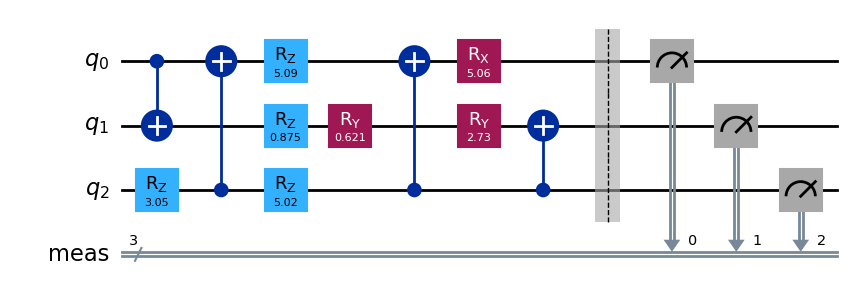

In [3]:
def generate_random_circuit(num_qubits: int, layers: int, measure: bool, seed: Optional[int] = None) -> QuantumCircuit:
    """
    Generates a random quantum circuit.

    Args:
        num_qubits (int): The number of qubits in the circuit.
        depth (int): The number of layers of random gates.
        seed (Optional[int]): Seed for random number generator for reproducibility.

    Returns:
        QuantumCircuit: The generated random quantum circuit.
    """

    one_qubit_gates = [RXGate(0), RYGate(0), RZGate(0)]
    two_qubit_gates = [CXGate()]
    rng = random.Random(seed);

    qc = QuantumCircuit(num_qubits) 

    for _ in range(layers):
        num_layer_2q_gates = rng.randint(0, num_qubits // 2) if num_qubits > 1 else 0
        qubits_not_used = list(range(num_qubits))
        num_layer_1q_gates = num_qubits - 2 * num_layer_2q_gates

        for _ in range(num_layer_2q_gates):
            gate = rng.choice(two_qubit_gates)
            q_ctrl, q_target = rng.sample(population=qubits_not_used, k=2)
            qubits_not_used.remove(q_ctrl)
            qubits_not_used.remove(q_target)
            qc.append(gate, [q_ctrl, q_target])

        for _ in range(num_layer_1q_gates):
            gate = rng.choice(one_qubit_gates)
            theta = rng.uniform(0, 2 * math.pi)
            gate = gate.__class__(theta)
            q_target = rng.sample(population=qubits_not_used, k=1)[0]
            qubits_not_used.remove(q_target)
            qc.append(gate, [q_target])
    
    # Add measurements at the end
    if measure:
        qc.measure_all()

    return qc

qc_f_0 = generate_random_circuit(num_qubits=3, layers=5, measure=True, seed=0)
qc_f_0.draw('mpl')

### Forward and reverse circuits
Compose a forward circuit and its inverse to capture program and state errors.


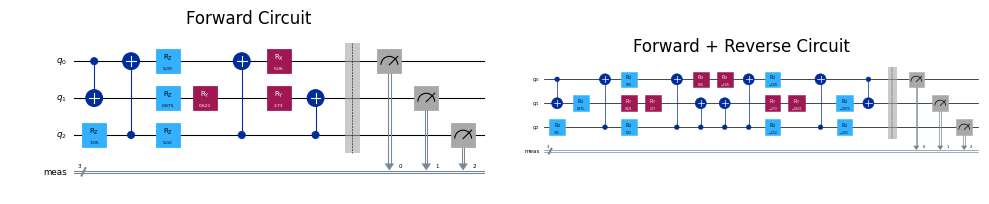

In [4]:
def generate_foward_reverse_circuit(qc_f: QuantumCircuit) -> tuple[QuantumCircuit, QuantumCircuit]:
    """
    Generates a pair of random quantum circuits: one forward, one foward + reverse.

    Args:
        qc (QuantumCircuit): The quantum circuit to be processed.

    Returns:
        tuple[QuantumCircuit, QuantumCircuit]: The generated forward and reverse quantum circuits.
    """
    
    base = qc_f.remove_final_measurements(inplace=False)
    reverse = base.inverse()

    qc_fr = QuantumCircuit(base.num_qubits)
    qc_fr.compose(base, inplace=True)
    qc_fr.compose(reverse, inplace=True)
    qc_fr.measure_all(inplace=True)
    return (qc_fr)
    
qc_fr_0 = generate_foward_reverse_circuit(qc_f_0)

fig, axs = plt.subplots(1, 2, figsize=(10,4))
qc_f_0.draw(output='mpl', ax=axs[0])
axs[0].set_title("Forward Circuit")

qc_fr_0.draw(output='mpl', ax=axs[1])
axs[1].set_title("Forward + Reverse Circuit")

plt.tight_layout()
plt.show()

## Step 2: Feature helpers

Utility functions convert counts to probabilities, execute circuits, and derive per-state features.


In [5]:
def counts_to_probs(counts: Counts, shots: int) -> Dict[str, float]:
    """Normalize a Qiskit counts dict to probabilities."""
    return {k: v / shots for k, v in counts.items()}

In [6]:
def run_circuits(qc: QuantumCircuit, backend, shots: int = 1024, trials: int = 10) -> tuple[List[Counts], List[Dict[str, float]]]:
    """
    Simulates the execution of a quantum circuit.

    Args:
        qc (QuantumCircuit): The quantum circuit to be executed.
        shots (int): The number of shots to simulate.

    Returns:
        dict: The counts of measurement outcomes.
    """
    
    tqc = transpile(qc, backend=backend)

    counts_trials: List[Counts] = []
    probs_trials: List[Dict[str, float]] = []

    for _ in range(trials):
        job = backend.run(tqc, shots=shots)
        result = job.result()
        counts = result.get_counts()
        counts_trials.append(counts)
        probs_trials.append(counts_to_probs(counts, shots))

    return counts_trials, probs_trials

In [7]:
def get_static_features(qc: QuantumCircuit, state: str) -> Dict[str, int]:
    """
    Get the necessary features (qubits) for a given quantum circuit.

    Args:
        qc (QuantumCircuit): The quantum circuit to analyze.
    """

    width = qc.num_qubits;
    depth = qc.depth();

    qc_operations = qc.count_ops()

    n_rx = qc_operations.get('rx', 0)
    n_ry = qc_operations.get('ry', 0)
    n_rz = qc_operations.get('rz', 0)
    n_cx = qc_operations.get('cx', 0)

    hamming_weight = state.count("1")

    features = {  
        "width": width,                     
        "depth": depth,                     
        "n_rx": n_rx,                             
        "n_ry": n_ry,                             
        "n_rz": n_rz,                             
        "n_cx": n_cx,
        "state_hamming_weight": hamming_weight                     
    }
    return features

In [8]:
def _pct(arr: List[float], q: float) -> float:
    """Compute the q-th percentile of a list with compatibility across NumPy versions."""
    a = np.asarray(arr, dtype=float)
    if a.size == 0:
        return float("nan")
    # numpy>=1.22 uses 'method'; older uses 'interpolation'
    try:
        return float(np.percentile(a, q, method="linear"))
    except TypeError:
        return float(np.percentile(a, q, interpolation="linear"))

def forward_state_features(
    probs_f_trials: List[Dict[str, float]], state: str
) -> Dict[str, float]:
    """Per-state percentiles of observed forward probabilities across trials."""
    vals = [trial.get(state, 0.0) for trial in probs_f_trials]
    return {
        "f_state_prob_p25": _pct(vals, 25),
        "f_state_prob_p50": _pct(vals, 50),
        "f_state_prob_p75": _pct(vals, 75),
    }

def fr_state_features(
    qc_fr: QuantumCircuit,
    probs_fr_trials: List[Dict[str, float]],
    state: str,
    correct_state: Optional[str] = None,
) -> Dict[str, float]:
    """
    Per-state percentiles of FR state-error for `state` across trials,
    plus circuit-level program-error percentiles (same for all states).
    """
    n = qc_fr.num_qubits
    corr = correct_state if correct_state is not None else ("0" * n)

    # state-error series for this state
    se_vals = []
    # program-error series for circuit (same for every state)
    pe_vals = []
    for trial in probs_fr_trials:
        p_corr = trial.get(corr, 0.0)
        pe_vals.append(1.0 - p_corr)
        p_s = trial.get(state, 0.0)
        se_vals.append((1.0 - p_s) if state == corr else p_s)

    return {
        "fr_state_error_p25": _pct(se_vals, 25),
        "fr_state_error_p50": _pct(se_vals, 50),
        "fr_state_error_p75": _pct(se_vals, 75),
        "fr_program_error_p25": _pct(pe_vals, 25),
        "fr_program_error_p50": _pct(pe_vals, 50),
        "fr_program_error_p75": _pct(pe_vals, 75),
    }

## Step 3: Dataset generation

Run simulations and assemble features into a training dataset stored on disk.


In [10]:
def generate_samples(num_samples: int) -> List[Dict]:
    """Simulate random circuits and collect statistics into a tabular dataset."""
    rng = random.Random()
    rows: List[Dict] = []
    backend = sim_noisy  # or sim_ideal

    for circuit_id in range(num_samples):
        # 1) circuits
        n = rng.randint(2, 5)
        layers = rng.randint(2, 10)
        qc_f  = generate_random_circuit(num_qubits=n, layers=layers, measure=True)
        qc_fr = generate_foward_reverse_circuit(qc_f)

        # 2) runs
        count_f_trials, probs_f_trials  = run_circuits(qc_f,  backend=backend, shots=400, trials=5)
        qc_f_true_probs = Statevector.from_instruction(qc_f.remove_final_measurements(inplace=False)).probabilities_dict()
        count_fr_trial, probs_fr_trials = run_circuits(qc_fr, backend=backend, shots=400, trials=5)

        # 3) all basis states (include zeros too)
        all_states = [format(i, f"0{n}b") for i in range(2**n)]
        corr = "0" * n

        # 4) build per-state rows
        for s in all_states:
            static = get_static_features(qc_f, s)
            f_feats  = forward_state_features(probs_f_trials, s)
            fr_feats = fr_state_features(qc_fr, probs_fr_trials, s, correct_state=corr)

            # label: FR mean probability for that state (proxy for true prob)
            true_p = qc_f_true_probs.get(s, 0.0)

            if true_p == 0.0:
                continue
            rows.append({
                "circuit_id": circuit_id,
                **static,
                **f_feats,
                **fr_feats,
                "state_bitstring": s,
                "true_probability": true_p,
            })

    return rows
samples = generate_samples(num_samples=100)

In [12]:
df = pd.DataFrame(samples)
df.to_csv("qraft_data.csv", index=False)
df = pd.read_csv("qraft_data.csv")

print("Rows, Cols:", df.shape)
df.head()


Rows, Cols: (1301, 19)


,circuit_id,width,depth,n_rx,n_ry,n_rz,n_cx,state_hamming_weight,f_state_prob_p25,f_state_prob_p50,f_state_prob_p75,fr_state_error_p25,fr_state_error_p50,fr_state_error_p75,fr_program_error_p25,fr_program_error_p50,fr_program_error_p75,state_bitstring,true_probability
0,0,2,8,2,1,3,4,0,0.3550,0.3575,0.3625,0.0950,0.1050,0.1075,0.0950,0.1050,0.1075,0,0.357546
1,0,2,8,2,1,3,4,1,0.3275,0.3600,0.3650,0.0725,0.0750,0.0900,0.0950,0.1050,0.1075,1,0.360146
2,0,2,8,2,1,3,4,1,0.1400,0.1525,0.1600,0.0150,0.0225,0.0250,0.0950,0.1050,0.1075,10,0.140643
3,0,2,8,2,1,3,4,2,0.1325,0.1375,0.1475,0.0000,0.0000,0.0000,0.0950,0.1050,0.1075,11,0.141665
4,1,2,10,3,3,8,2,0,0.0300,0.0375,0.0375,0.0975,0.0975,0.1100,0.0975,0.0975,0.1100,0,0.018911


## Prediction Model

Train an ensemble decision tree to predict ideal state probabilities from noisy observations.


In [ ]:
RANDOM_STATE = 0

FEATURE_COLS = [c for c in df.columns if c not in ["circuit_id","state_bitstring", "true_probability"]]
TARGET_COL = "true_probability"

X = df[FEATURE_COLS].copy()
y = df[TARGET_COL].astype(float).copy()

# Train/test split 85/15
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_STATE, shuffle=True
)

In [14]:
def build_edt(
    """Construct an ensemble decision tree regressor (bagging or AdaBoost)."""
    ensemble="bag",
    n_estimators=200,
    learning_rate=0.1,
    max_depth=None,
    max_leaf_nodes=None,
    criterion="squared_error",   # CART regression split criteria
    random_state=RANDOM_STATE,
):
    base = DecisionTreeRegressor(
        criterion=criterion,
        max_depth=max_depth,
        max_leaf_nodes=max_leaf_nodes,
        random_state=random_state,
    )
    if ensemble == "bag":
        model = BaggingRegressor(
            estimator=base,
            n_estimators=n_estimators,
            bootstrap=True,
            n_jobs=-1,
            random_state=random_state,
        )
    elif ensemble == "adaboost":
        model = AdaBoostRegressor(
            estimator=base,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=random_state,
        )
    else:
        raise ValueError("ensemble must be 'bag' or 'adaboost'")
    return Pipeline([("model", model)])

In [15]:
space = [
    Categorical(["bag", "adaboost"], name="ensemble"),
    Integer(50, 400, name="n_estimators"),
    Real(1e-3, 0.5, prior="log-uniform", name="learning_rate"),
    Integer(2, 32, name="max_depth"),
    Integer(4, 256, name="max_leaf_nodes"),
    Categorical(["squared_error", "friedman_mse"], name="criterion"),
]

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

@use_named_args(space)
def objective(**params):
    model = build_edt(**params, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scorer, n_jobs=-1)
    return -scores.mean()  # minimize MAE

In [16]:
opt_res = gp_minimize(
    objective,
    dimensions=space,
    acq_func="EI",
    n_calls=40,
    n_initial_points=10,
    random_state=RANDOM_STATE,
)

best = dict(zip([d.name for d in space], opt_res.x))
print("Best hyperparams:", best)
print("Estimated CV MAE:", opt_res.fun)

Best hyperparams: {'ensemble': np.str_('bag'), 'n_estimators': np.int64(51), 'learning_rate': 0.07271444427032642, 'max_depth': np.int64(27), 'max_leaf_nodes': np.int64(235), 'criterion': np.str_('friedman_mse')}
Estimated CV MAE: 0.007385931931994019


In [17]:
best_model = build_edt(**best, random_state=RANDOM_STATE)
best_model.fit(X_train, y_train)

y_pred_raw = np.clip(best_model.predict(X_test), 0.0, 1.0)

# Normalize to valid probability distribution (sum=1 over test set)
y_pred = y_pred_raw / y_pred_raw.sum()

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
l1_total = float(np.abs(y_test - y_pred).sum())

print(f"Test MAE:  {mae:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"L1 sum abs diff: {l1_total:.6f}")

Test MAE:  0.072399
Test RMSE: 0.140084
L1 sum abs diff: 14.190286


### Evaluate model predictions
Compare the trained model against the noisy baseline using standard error metrics.


In [18]:
# After you have best_model, X_test, y_test

# Raw predictions
y_pred_raw = np.clip(best_model.predict(X_test), 0.0, 1.0)

# Renormalize across the test set so probabilities sum to 1
y_pred = y_pred_raw / y_pred_raw.sum()

# Build test_df
test_df = pd.DataFrame({
    "true_probability": y_test.values,
    "y_pred_raw": y_pred_raw,
    "y_pred": y_pred
}, index=y_test.index)

# If you want to keep state_bitstring in there too
if "state_bitstring" in df.columns:
    test_df["state_bitstring"] = df.loc[test_df.index, "state_bitstring"]


In [19]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import numpy as np

# true values
y_true = df["true_probability"]

# noisy backend (using forward median as proxy)
y_noisy = df["f_state_prob_p50"]

# model predictions (from test set eval)
y_model = test_df["y_pred"]   # or y_pred_norm, depending on what you saved

# Errors
mae_noisy = mean_absolute_error(y_true, y_noisy)
rmse_noisy = root_mean_squared_error(y_true, y_noisy)
tvd_noisy = 0.5 * np.abs(y_true - y_noisy).sum()

mae_model = mean_absolute_error(y_true.loc[test_df.index], y_model)
rmse_model = root_mean_squared_error(y_true.loc[test_df.index], y_model)
tvd_model = 0.5 * np.abs(y_true.loc[test_df.index] - y_model).sum()

print("Noisy backend:")
print(f"  MAE  = {mae_noisy:.4f}")
print(f"  RMSE = {rmse_noisy:.4f}")
print(f"  TVD  = {tvd_noisy:.4f}")

print("\nModel corrected:")
print(f"  MAE  = {mae_model:.4f}")
print(f"  RMSE = {rmse_model:.4f}")
print(f"  TVD  = {tvd_model:.4f}")


Noisy backend:
  MAE  = 0.0104
  RMSE = 0.0190
  TVD  = 6.7724

Model corrected:
  MAE  = 0.0724
  RMSE = 0.1401
  TVD  = 7.0951
